##quantum approximate q-learning with pqcs##

deep q-learning --> quantum version
- approximate the optimal state-action pair Q*(s, a)
- uses deep neural network, here named deep q-network (dqn)
- substitute deep neural network with quantum parametric circuit
- nn in qiskit-machine-learning, eval gradients in torch, cartpole env in gymnasium

In [1]:
# general imports
import numpy as np
import matplotlib.pyplot as plt

# qiskit circuit imports
from qiskit.circuit import QuantumCircuit, QuantumRegister, Parameter, ParameterVector, ParameterExpression
from qiskit.circuit.library import TwoLocal

# qiskit imports
import qiskit as qk
# from qiskit.utils import QuantumInstance # replace w https://docs.quantum.ibm.com/migration-guides/qiskit-quantum-instance

# qiskit machine learning imports https://medium.com/qiskit/introducing-qiskit-machine-learning-0-6-25186b57bf97
# import qiskit_machine_learning as qkml
# from qiskit_machine_learning.neural_networks import CircuitQNN
# from qiskit_machine_learning.connectors import TorchConnector

# pytorch imports
import torch
from torch import Tensor
from torch.nn import MSELoss
from torch.optim import LBFGS, SGD, Adam, RMSprop

# OpenAI Gym import
import gymnasium as gym

# Fix seed for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# to get smooth animations on jupyter notebooks
# note: these plotting functions are taken from https://github.com/ageron/handson-ml2
import matplotlib as mpl
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

choose 2 circuits
1. encoding_circuit: encoding method for classical data
- state variables of cartpole [a, b, c, d]
- |0000> ===> use rx rotations
2. parametrized_circuit: parametrized variational circuit
- variational ansatz:
- repeated structure of ry and rz rotations
- circular entangled scheme of cz gates
- choices:
- choose number of repetitions (layers)
- y/n data reuploading at start of each layer

In [2]:
def encoding_circuit(inputs, num_qubits = 4, *args):
    qc = qk.QuantumCircuit(num_qubits)
    for i in range(len(inputs)):
        qc.rx(inputs[i], i)
    return qc

def parametrized_circuit(num_qubits = 4, reuploading = False, reps = 2, insert_barriers = True, meas = False):
    qr = qk.QuantumRegister(num_qubits, 'qr')
    qc = qk.QuantumCircuit(qr)

    if meas:
        qr = qk.QuantumRegister(num_qubits, 'qr')
        cr = qk.ClassicalRegister(num_qubits, 'cr')
        qc = qk.QuantumCircuit(qr, cr)

    if not reuploading:
        # encoding
        inputs = qk.circuit.ParameterVector('x', num_qubits)
        qc.compose(encoding_circuit(inputs, num_qubits=num_qubits), inplace=True)
        if insert_barriers: qc.barrier()

        # variational ansatz
        qc.compose(TwoLocal(num_qubits, 
                            ['ry', 'rz'], 
                            'cz', 
                            'circular',
                            reps=reps,
                            insert_barriers=insert_barriers,
                            skip_final_rotation_layer=True), inplace = True)
        if insert_barriers: qc.barrier()

        # measure
        if meas: qc.measure(qr, cr)

    elif reuploading:
        inputs = qk.circuit.ParameterVector('x', num_qubits)
        θ = qk.circuit.ParameterVector('θ', 2 * num_qubits * reps)
        for rep in range(reps):

            # encoding
            qc.compose(encoding_circuit(inputs, num_qubits=num_qubits), inplace = True)
            if insert_barriers: qc.barrier()

            # variational ansatz
            for qubit in range(num_qubits):
                qc.ry(θ[qubit + 2 * num_qubits * rep], qubit)
                qc.rz(θ[qubit + 2 * num_qubits * rep + num_qubits], qubit)
            if insert_barriers: qc.barrier()
            qc.cz(qr[-1], qr[0])
            for qubit in range(num_qubits - 1):
                qc.cz(qr[qubit], qr[qubit + 1])
            if insert_barriers: qc.barrier()

        # measure
        if meas: qc.measure(qr, cr)

    return qc

In [3]:
num_qubits = 4
qc = parametrized_circuit(num_qubits = num_qubits,
                          reuploading = True,
                          reps = 6)
X = list(qc.parameters)[: num_qubits]
params = list(qc.parameters)[num_qubits:]
qc.draw()

┌──────────┐ ░ ┌──────────┐┌──────────┐ ░              ░ ┌──────────┐ ░ »
qr_0: ┤ Rx(x[0]) ├─░─┤ Ry(θ[0]) ├┤ Rz(θ[4]) ├─░──■──■────────░─┤ Rx(x[0]) ├─░─»
      ├──────────┤ ░ ├──────────┤├──────────┤ ░  │  │        ░ ├──────────┤ ░ »
qr_1: ┤ Rx(x[1]) ├─░─┤ Ry(θ[1]) ├┤ Rz(θ[5]) ├─░──┼──■──■─────░─┤ Rx(x[1]) ├─░─»
      ├──────────┤ ░ ├──────────┤├──────────┤ ░  │     │     ░ ├──────────┤ ░ »
qr_2: ┤ Rx(x[2]) ├─░─┤ Ry(θ[2]) ├┤ Rz(θ[6]) ├─░──┼─────■──■──░─┤ Rx(x[2]) ├─░─»
      ├──────────┤ ░ ├──────────┤├──────────┤ ░  │        │  ░ ├──────────┤ ░ »
qr_3: ┤ Rx(x[3]) ├─░─┤ Ry(θ[3]) ├┤ Rz(θ[7]) ├─░──■────────■──░─┤ Rx(x[3]) ├─░─»
      └──────────┘ ░ └──────────┘└──────────┘ ░              ░ └──────────┘ ░ »
«       ┌──────────┐┌───────────┐ ░              ░ ┌──────────┐ ░ ┌───────────┐»
«qr_0: ─┤ Ry(θ[8]) ├┤ Rz(θ[12]) ├─░──■──■────────░─┤ Rx(x[0]) ├─░─┤ Ry(θ[16]) ├»
«       ├──────────┤├───────────┤ ░  │  │        ░ ├──────────┤ ░ ├───────────┤»
«qr_1: ─┤ Ry(θ[9]) ├┤ Rz(θ[13]) ├─░──┼──■──■─────░─┤ Rx(x[1]) ├─░─┤ Ry(θ[17]) ├»
«      ┌┴──────────┤├───────────┤ ░  │     │     ░ ├──────────┤ ░ ├───────────┤»
«qr_2: ┤ Ry(θ[10]) ├┤ Rz(θ[14]) ├─░──┼─────■──■──░─┤ Rx(x[2]) ├─░─┤ Ry(θ[18]) ├»
«      ├───────────┤├───────────┤ ░  │        │  ░ ├──────────┤ ░ ├───────────┤»
«qr_3: ┤ Ry(θ[11]) ├┤ Rz(θ[15]) ├─░──■────────■──░─┤ Rx(x[3]) ├─░─┤ Ry(θ[19]) ├»
«      └───────────┘└───────────┘ ░              ░ └──────────┘ ░ └───────────┘»
«      ┌───────────┐ ░              ░ ┌──────────┐ ░ ┌───────────┐┌───────────┐»
«qr_0: ┤ Rz(θ[20]) ├─░──■──■────────░─┤ Rx(x[0]) ├─░─┤ Ry(θ[24]) ├┤ Rz(θ[28]) ├»
«      ├───────────┤ ░  │  │        ░ ├──────────┤ ░ ├───────────┤├───────────┤»
«qr_1: ┤ Rz(θ[21]) ├─░──┼──■──■─────░─┤ Rx(x[1]) ├─░─┤ Ry(θ[25]) ├┤ Rz(θ[29]) ├»
«      ├───────────┤ ░  │     │     ░ ├──────────┤ ░ ├───────────┤├───────────┤»
«qr_2: ┤ Rz(θ[22]) ├─░──┼─────■──■──░─┤ Rx(x[2]) ├─░─┤ Ry(θ[26]) ├┤ Rz(θ[30]) ├»
«      ├───────────┤ ░  │        │  ░ ├──────────┤ ░ ├───────────┤├───────────┤»
«qr_3: ┤ Rz(θ[23]) ├─░──■────────■──░─┤ Rx(x[3]) ├─░─┤ Ry(θ[27]) ├┤ Rz(θ[31]) ├»
«      └───────────┘ ░              ░ └──────────┘ ░ └───────────┘└───────────┘»
«       ░              ░ ┌──────────┐ ░ ┌───────────┐┌───────────┐ ░          »
«qr_0: ─░──■──■────────░─┤ Rx(x[0]) ├─░─┤ Ry(θ[32]) ├┤ Rz(θ[36]) ├─░──■──■────»
«       ░  │  │        ░ ├──────────┤ ░ ├───────────┤├───────────┤ ░  │  │    »
«qr_1: ─░──┼──■──■─────░─┤ Rx(x[1]) ├─░─┤ Ry(θ[33]) ├┤ Rz(θ[37]) ├─░──┼──■──■─»
«       ░  │     │     ░ ├──────────┤ ░ ├───────────┤├───────────┤ ░  │     │ »
«qr_2: ─░──┼─────■──■──░─┤ Rx(x[2]) ├─░─┤ Ry(θ[34]) ├┤ Rz(θ[38]) ├─░──┼─────■─»
«       ░  │        │  ░ ├──────────┤ ░ ├───────────┤├───────────┤ ░  │       »
«qr_3: ─░──■────────■──░─┤ Rx(x[3]) ├─░─┤ Ry(θ[35]) ├┤ Rz(θ[39]) ├─░──■───────»
«       ░              ░ └──────────┘ ░ └───────────┘└───────────┘ ░          »
«          ░ ┌──────────┐ ░ ┌───────────┐┌───────────┐ ░              ░ 
«qr_0: ────░─┤ Rx(x[0]) ├─░─┤ Ry(θ[40]) ├┤ Rz(θ[44]) ├─░──■──■────────░─
«          ░ ├──────────┤ ░ ├───────────┤├───────────┤ ░  │  │        ░ 
«qr_1: ────░─┤ Rx(x[1]) ├─░─┤ Ry(θ[41]) ├┤ Rz(θ[45]) ├─░──┼──■──■─────░─
«          ░ ├──────────┤ ░ ├───────────┤├───────────┤ ░  │     │     ░ 
«qr_2: ─■──░─┤ Rx(x[2]) ├─░─┤ Ry(θ[42]) ├┤ Rz(θ[46]) ├─░──┼─────■──■──░─
«       │  ░ ├──────────┤ ░ ├───────────┤├───────────┤ ░  │        │  ░ 
«qr_3: ─■──░─┤ Rx(x[3]) ├─░─┤ Ry(θ[43]) ├┤ Rz(θ[47]) ├─░──■────────■──░─
«          ░ └──────────┘ ░ └───────────┘└───────────┘ ░              ░

In [4]:
from qiskit.providers.basic_provider import BasicSimulator
# qiskit-machine-learning modules
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit.primitives import StatevectorEstimator
from qiskit_machine_learning.connectors import TorchConnector
estimator = StatevectorEstimator()

backend = BasicSimulator()

qnn = EstimatorQNN(circuit = qc,
                   estimator = estimator,
                   input_params = X,
                   weight_params = params)

initial_weights = (2 * np.random.rand(qnn.num_weights) - 1)
quantum_nn = TorchConnector(qnn, initial_weights)


classical pre and post processing layers

encoding_layer (diff from encoding_circuit)
- arctan(classical inputs . trainable parameters)

exp_val_layer (output of q circ (prob of |0000>, ... |1111>) -> expectation values <Z_0 Z_1> and <Z_2 Z_3> rewards Q(s, a) of a = left or right

In [5]:
class encoding_layer(torch.nn.Module):
    def __init__(self, num_qubits = 4):
        super().__init__()
        weights = torch.Tensor(num_qubits)
        self.weights = torch.nn.Parameter(weights)
        torch.nn.init.uniform_(self.weights, -1, 1)
    
    def forward(self, x):
        if not isinstance(x, Tensor):
            x = Tensor(x)
        x = self.weights * x
        x = torch.atan(x)
        return x

In [6]:
class exp_val_layer(torch.nn.Module):
    def __init__(self, action_space = 2):
        super().__init__()
        weights = torch.Tensor(action_space)
        self.weights = torch.nn.Parameter(weights)
        torch.nn.init.uniform_(self.weights, 35, 40)
        self.mask_ZZ_12 = torch.tensor([1.,-1.,-1.,1.,1.,-1.,-1.,1.,1.,-1.,-1.,1.,1.,-1.,-1.,1.], requires_grad = False)
        self.mask_ZZ_34 = torch.tensor([-1.,-1.,-1.,-1.,1.,1.,1.,1.,-1.,-1.,-1.,-1.,1.,1.,1.,1.], requires_grad = False)
    def forward(self, x):
        expval_ZZ_12 = self.mask_ZZ_12 * x
        expval_ZZ_34 = self.mask_ZZ_34 * x 
        if len(x.shape) == 1:
            expval_ZZ_12 = torch.sum(expval_ZZ_12)
            expval_ZZ_34 = torch.sum(expval_ZZ_34)
            out = torch.cat((expval_ZZ_12.unsqueeze(0), expval_ZZ_34.unsqueeze(0)))
        else:
            expval_ZZ_12 = torch.sum(expval_ZZ_12)
            expval_ZZ_34 = torch.sum(expval_ZZ_34)
            out = torch.cat((expval_ZZ_12.unsqueeze(0), expval_ZZ_34.unsqueeze(0)))
        return self.weights * ((out + 1.) / 2.)

In [7]:
encoding = encoding_layer()
exp_val = exp_val_layer()
model = torch.nn.Sequential(encoding,
                            quantum_nn,
                            exp_val)

model.state_dict()

OrderedDict([('0.weights', tensor([ 0.7645,  0.8300, -0.2343,  0.9186])),
             ('1.weight',
              tensor([-0.2509,  0.9014,  0.4640,  0.1973, -0.6880, -0.6880, -0.8838,  0.7324,
                       0.2022,  0.4161, -0.9588,  0.9398,  0.6649, -0.5753, -0.6364, -0.6332,
                      -0.3915,  0.0495, -0.1361, -0.4175,  0.2237, -0.7210, -0.4157, -0.2673,
                      -0.0879,  0.5704, -0.6007,  0.0285,  0.1848, -0.9071,  0.2151, -0.6590,
                      -0.8699,  0.8978,  0.9313,  0.6168, -0.3908, -0.8047,  0.3685, -0.1197,
                      -0.7559, -0.0096, -0.9312,  0.8186, -0.4824,  0.3250, -0.3766,  0.0401])),
             ('1._weights',
              tensor([-0.2509,  0.9014,  0.4640,  0.1973, -0.6880, -0.6880, -0.8838,  0.7324,
                       0.2022,  0.4161, -0.9588,  0.9398,  0.6649, -0.5753, -0.6364, -0.6332,
                      -0.3915,  0.0495, -0.1361, -0.4175,  0.2237, -0.7210, -0.4157, -0.2673,
                      -

In [8]:
# Decomment and execute the following lines to create a fully classical neural network, instead of the quantum one

model = torch.nn.Sequential(torch.nn.Linear(4,32),
                            torch.nn.ELU(),
                            torch.nn.Linear(32,32),
                            torch.nn.ELU(),
                            torch.nn.Linear(32,2))

# Print the weights of the classical neural network
model.state_dict()

# Print the total number of weights in the classical neural network
pytorch_total_params = sum(p.numel() for p in model.parameters())

In [1]:
import gymnasium as gym

In [2]:
env = gym.make("CartPole-v1", render_mode = "human")
input_shape = [4] # == env.observation_space.shape
n_outputs = 2 # == env.action_space.n

In [3]:
env.reset()
env.step(0)

(array([-0.01641314, -0.1691247 ,  0.02483817,  0.3211866 ], dtype=float32),
 1.0,
 False,
 False,
 {})

: 

training

In [10]:
from collections import deque

replay_memory = deque(maxlen=2000)

In [11]:
batch_size = 16
discount_rate = 0.99
optimizer = Adam(model.parameters(), lr=1e-2)

In [12]:
def epsilon_greedy_policy(state, epsilon=0):
    """Manages the transition from the *exploration* to *exploitation* phase"""
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)
    else:
        with torch.no_grad():
            Q_values = model(Tensor(state)).numpy()
        return np.argmax(Q_values[0])
    
def sample_experiences(batch_size):
    """Sample some past experiences from the replay memory"""
    indices = np.random.randint(len(replay_memory), size=batch_size)
    batch = [replay_memory[index] for index in indices]
    states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)]
    return states, actions, rewards, next_states, dones

def play_one_step(env, state, epsilon):
    """Perform one action in the environment and register the state of the system"""
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, truncated, info = env.step(action)
    replay_memory.append((state, action, reward, next_state, done))
    return next_state, reward, done, info

def sequential_training_step(batch_size):
    """
    Actual training routine. Implements the Deep Q-Learning algorithm.
    
    This implementation evaluates individual losses sequentially instead of using batches. 
    This is due to an issue in the TorchConnector, which yields vanishing gradients if it 
    is called with a batch of data (see https://github.com/Qiskit/qiskit-machine-learning/issues/100).
    
    Use this training for the quantum model. If using the classical model, you can use indifferently 
    this implementation or the batched one below. 
    """
    
    # Sample past experiences 
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    
    # Evaluates Target Q-values
    with torch.no_grad():
        next_Q_values = model(Tensor(next_states)).numpy()
    max_next_Q_values = np.max(next_Q_values, axis=1)
    target_Q_values = (rewards + (1 - dones) * discount_rate * max_next_Q_values)
    
    # Accumulate Loss sequentially (if batching data, gradients of the parameters are vanishing)
    loss = 0.
    for j, state in enumerate(states):
        single_Q_value = model(Tensor(state))
        Q_value = single_Q_value[actions[j]]
        loss += (target_Q_values[j] - Q_value)**2
    
    # Evaluate the gradients and update the parameters 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

def training_step(batch_size):
    """
    This is exactly the same function as sequential_training_step, except that it 
    evaluates loss with batch of data, instead of using a for loop. 
    
    Can use this if training the classical model.
    """
    
    # Sample past experiences
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    
    # Evaluate Target Q-values
    with torch.no_grad():
        next_Q_values = model(Tensor(next_states)).numpy()
    max_next_Q_values = np.max(next_Q_values, axis=1)
    target_Q_values = (rewards +
                       (1 - dones) * discount_rate * max_next_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = torch.nn.functional.one_hot(Tensor(actions).long(), n_outputs)
    
    # Evaluate the loss
    all_Q_values = model(Tensor(states))
    Q_values = torch.sum(all_Q_values * mask, dim=1, keepdims=True)
    loss = loss_fn(Tensor(target_Q_values), Q_values)
    
    # Evaluate the gradients and update the parameters 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [21]:
rewards = [] 
best_score = 0

# We let the agent train for 2000 episodes
for episode in range(2000):
    
    # Run enviroment simulation
    obs = env.reset()  
    
    # 200 is the target score for considering the environment solved
    for step in range(200):
        
        # Manages the transition from exploration to exploitation
        epsilon = max(1 - episode / 1500, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break
    rewards.append(step)
    
    # Saving best agent
    if step >= best_score:
        torch.save(model.state_dict(), './new_model_best_weights.pth') # Save best weights
        best_score = step
        
    print("\rEpisode: {}, Steps : {}, eps: {:.3f}".format(episode, step + 1, epsilon), end="")
    
    # Start training only after some exploration experiences  
    if episode > 20:
        sequential_training_step(batch_size)

Episode: 15, Steps : 13, eps: 0.990

ValueError: expected sequence of length 4 at dim 1 (got 0)

In [16]:
model.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.2476,  0.2987,  0.4597, -0.3711],
                      [ 0.4488,  0.1132,  0.3495,  0.0481],
                      [ 0.2578, -0.0506,  0.3656,  0.0539],
                      [-0.2147,  0.1374, -0.2330, -0.0675],
                      [-0.1935,  0.3481, -0.4128, -0.2502],
                      [-0.1218, -0.2893,  0.0420, -0.5046],
                      [ 0.4603, -0.4064,  0.3661,  0.0647],
                      [-0.1718,  0.2926,  0.0956,  0.4219],
                      [ 0.0352, -0.1686,  0.1159, -0.1256],
                      [ 0.1961,  0.4266,  0.3078, -0.1990],
                      [ 0.3043,  0.1090,  0.2339, -0.3243],
                      [-0.4849, -0.1753, -0.4007,  0.3918],
                      [ 0.1605,  0.2193,  0.1548, -0.0209],
                      [ 0.4016, -0.3361,  0.0117, -0.3604],
                      [ 0.1345, -0.1811,  0.1344, -0.0964],
                      [ 0.3988, -0.3050, -0.3172, -0.2903],
              

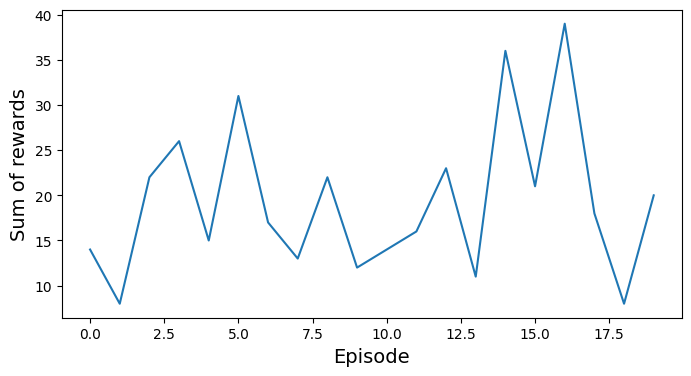

In [17]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.show()

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# This file contains the sum of rewards from a previous successfull training run
rewards_history = np.loadtxt("training_rewards2.txt") + 1

cmap = plt.get_cmap('tab20c')

fig = plt.figure(figsize=(8,5))
plt.axhline([200], ls = 'dashed', c=cmap(9))
plt.text(-50,190, s='Max reward', c=cmap(8))

plt.text(-50,100, s='Exploration\nphase', c=cmap(12))
plt.text(1100,100, s='Exploitation\nphase', c=cmap(12))

plt.plot(rewards_history, c = cmap(4))
plt.xlabel("Episodes")
plt.ylabel("Final reward")

plt.tight_layout()
plt.show()


FileNotFoundError: training_rewards2.txt not found.

In [20]:
state = env.reset()

frames = []
for step in range(200):
    action = epsilon_greedy_policy(state)
    state, reward, done, info = env.step(action)
    if done:
        print("End at step:", step)
        break
    img = env.render(mode="rgb_array")
    frames.append(img)
    
plot_animation(frames)

/var/folders/tj/699by59d2xn3cxcn9yhkp4540000gn/T/ipykernel_90892/249124523.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  Q_values = model(Tensor(state)).numpy()


ValueError: expected sequence of length 4 at dim 1 (got 0)